**Deep Learning AA 2023/2024**
** **
Teachers:\
Fabrizio Silvestri (fsilvestri@diag.uniroma1.it)\
Antonio Purificato (purificato@diag.uniroma1.it)\
Farooq Wani (wani@diag.uniroma1.it)\
Maria Sofia Bucarelli (bucarelli@diag.uniroma1.it) \

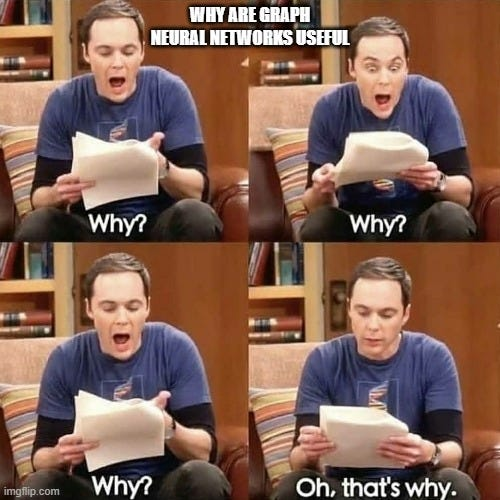

# Installation

In [ ]:
#@title Install required libraries
%%capture

import os
import torch
os.environ['TORCH'] = torch.__version__

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install networkx

!pip install mycolorpy
!pip install colorama

In [ ]:
#@title Import modules
import numpy as np
import seaborn as sns
import math
import itertools
import scipy as sp
import scipy.linalg
from scipy.linalg import block_diag
import random
from typing import Mapping, Tuple, Sequence, List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum, scatter_add
from torch_geometric.utils import to_dense_adj, to_undirected, remove_self_loops
from torch.nn import Embedding
from torch.nn import Parameter

import pdb

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import matplotlib.cm as cm
import colorama

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# @title Helper functions for plots and visualisations

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)

    return training_stats


def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)

    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))


# Part 0: Warmup

A  classic dataset for GNNs (one whose use is also discouraged within some circles as it is very easy to overfit on), Cora is a nice small dataset to start looking at GNNs. There are many variations of the Cora dataset originally presented in "Automating the Construction of Internet Portals with Machine Learning" by McCallum et al. (https://link.springer.com/article/10.1023/A:1009953814988).

We will use the Cora dataset variant as presented in “FastGCN: Fast Learning with Graph Convolutional Networks via Importance Sampling” (https://arxiv.org/abs/1801.10247).


*   There are 2708 papers (i.e. observations in the dataset)
  * 1208 train
  * 500 validation
  * 1000 test
*   Each paper is represented by a 1433 dimensional bag-of-words vector
*   Each paper belongs to one of 7 classes

We will work with the cora dataset through a `CoraDataset` object which will download the dataset and provides the following methods:

- `train_val_test_split(self)`: returns torch tensors for `train_x`, `train_y`, `validation_x`, `validation_y`, `test_x`, `test_y`, corresponding to input x and target y for each of the train/val/test splits.
- `get_fullx(self)`: returns the feature matrix $\mathbf{X} \in \mathbb{R}^{|V| \times d}$ where $V$ is the set of nodes and $d$ the feature vector dimensionality.
- `get_adjacency_matrix(self)`: As the name suggests, returns a dense adjacency matrix $\mathbf{A}$
- `get_edge_index(self)`: Returns the sparse adjacency matrix in the form of a matrix of shape (2, num_edges)

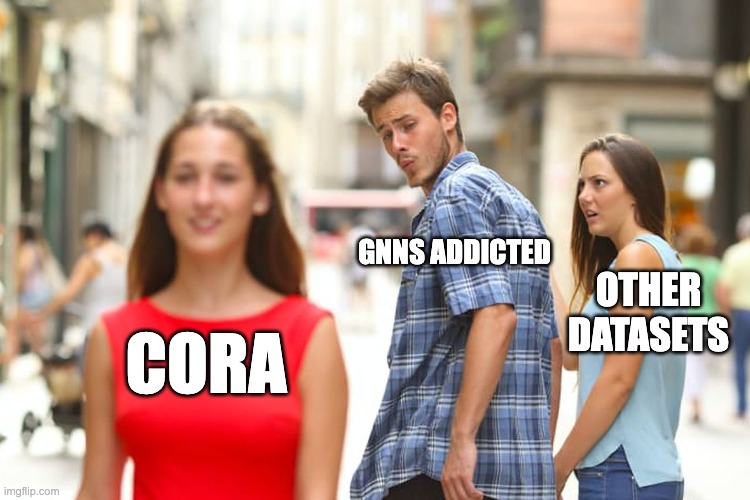

In [ ]:
# @title `CoraDataset` implementation

class CoraDataset(object):
    def __init__(self):
        super(CoraDataset, self).__init__()
        cora_pyg = Planetoid(root='/tmp/Cora', name='Cora', split="full")
        self.cora_data = cora_pyg[0]
        self.train_mask = self.cora_data.train_mask
        self.valid_mask = self.cora_data.val_mask
        self.test_mask = self.cora_data.test_mask

    def train_val_test_split(self):
        train_x = self.cora_data.x[self.cora_data.train_mask]
        train_y = self.cora_data.y[self.cora_data.train_mask]

        valid_x = self.cora_data.x[self.cora_data.val_mask]
        valid_y = self.cora_data.y[self.cora_data.val_mask]

        test_x = self.cora_data.x[self.cora_data.test_mask]
        test_y = self.cora_data.y[self.cora_data.test_mask]
        return train_x, train_y, valid_x, valid_y, test_x, test_y

    def get_fullx(self):
        return self.cora_data.x

    def get_edge_index(self):
        return self.cora_data.edge_index

    def get_adjacency_matrix(self):
        # We will ignore this for the first part
        adj = to_dense_adj(self.cora_data.edge_index)[0]
        return adj

In [ ]:
# Lets download our cora dataset and get the splits
cora_data = CoraDataset() ###<- n.b. should change this as "cora_data" is an attribute of CoraDataset
train_x, train_y, valid_x, valid_y, test_x, test_y = cora_data.train_val_test_split()

# Always check and confirm our data shapes match our expectations
print(f"Train shape x: {train_x.shape}, y: {train_y.shape}")
print(f"Val shape x: {valid_x.shape}, y: {valid_y.shape}")
print(f"Test shape x: {test_x.shape}, y: {test_y.shape}")

Processing...
Done!


Train shape x: torch.Size([1208, 1433]), y: torch.Size([1208])
Val shape x: torch.Size([500, 1433]), y: torch.Size([500])
Test shape x: torch.Size([1000, 1433]), y: torch.Size([1000])


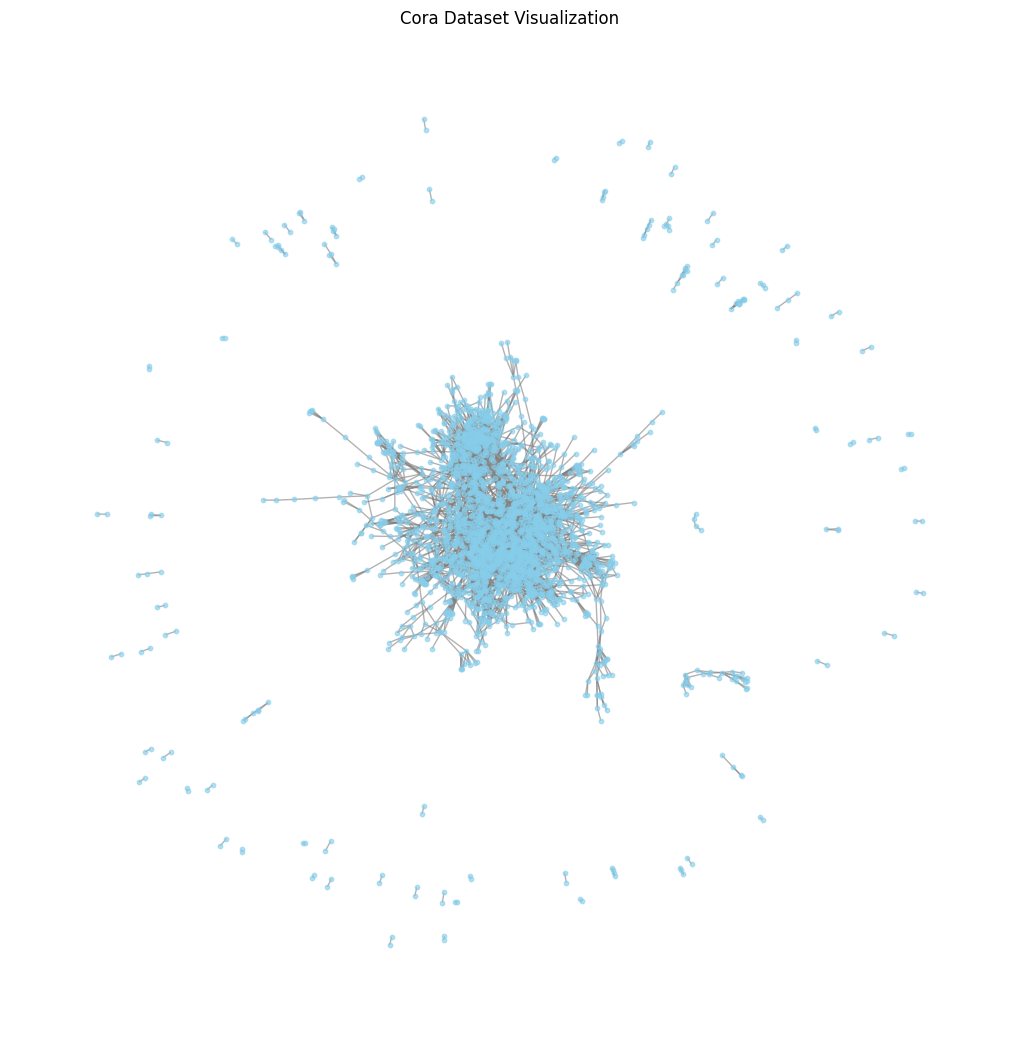

In [ ]:
G = torch_geometric.utils.to_networkx(cora_data.cora_data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_size=10, node_color='skyblue', edge_color='gray', alpha=0.6)
plt.title('Cora Dataset Visualization')
plt.show()

# Part 1: From Heat Diffusion to GNNs






## Compute the symmetric normalised adjacency matrix of a graph with added self-lopps.

For a graph without self loops, this is given by $(D + I)^{-
1/2}(A + I)(D + I)^{-1/2}$. The function below takes as input the dense matrix $A$ and should return a sparse version of the normalised adjacency in the coordinate format: https://pytorch.org/docs/stable/sparse.html#sparse-coo-docs

In [ ]:
def sym_norm_adj(A):
    #### Create the symmetric normalised adjacency from the dense adj matrix A
    # This should return a sparse adjacency matrix. (torch sparse coo tensor format)
    A_tilde = A + torch.eye(A.shape[0])
    D_tilde = torch.diag(torch.sum(A_tilde, axis=1))
    D_tilde_inv_sqrt = torch.pow(D_tilde, -0.5)
    D_tilde_inv_sqrt[torch.isinf(D_tilde_inv_sqrt)] = 0.0
    A_tilde = A_tilde.to_sparse()
    D_tilde_inv_sqrt = D_tilde_inv_sqrt.to_sparse()
    adj_norm = torch.sparse.mm(torch.sparse.mm(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt)
    return adj_norm

## Implement a function to compute the Dirichlet energy

For a feature matrix $X$, the Dirichlet energy is defined as $Tr(X^T \Delta X)$, where $\Delta$ is the symmetric normalised Laplacian. This is a measure of how smooth our signal is. While not ideal (as Francesco also discuses in his talk), it is sufficient for our purposes. Think how this can be implemented as efficiently as possible.



In [ ]:
def dirichlet_energy(X, adj_norm):
    # X is a matrix of shape (num_nodes, feature_channels)
    # adj_norm is a torch sparse coo tensor
    X = X.detach()
    LX = X - torch.sparse.mm(adj_norm, X)
    energy = (X * LX).sum()
    return energy

##Test the code by computing the Dirichlet energy on the raw features of Cora.

In [ ]:
X = cora_data.get_fullx()
adj = cora_data.get_adjacency_matrix()
norm_adj = sym_norm_adj(adj)
energy = dirichlet_energy(X, norm_adj)
print(f"Initial Dirichlet enegy: {energy}")

Initial Dirichlet enegy: 30079.66015625


<ipython-input-8-1b9ff9b01a88>:10: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj_norm = torch.sparse.mm(torch.sparse.mm(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt)


##Implement the heat layer

We will now implement an Euler discretisation of heat diffusion. The heat diffusion equation is given by $\frac{\partial X}{\partial t} = -\Delta_0 X(t)$. For a step size $h$, we obtain the following layer $X_{n+1} = X_n - h \Delta_0 X_n$.

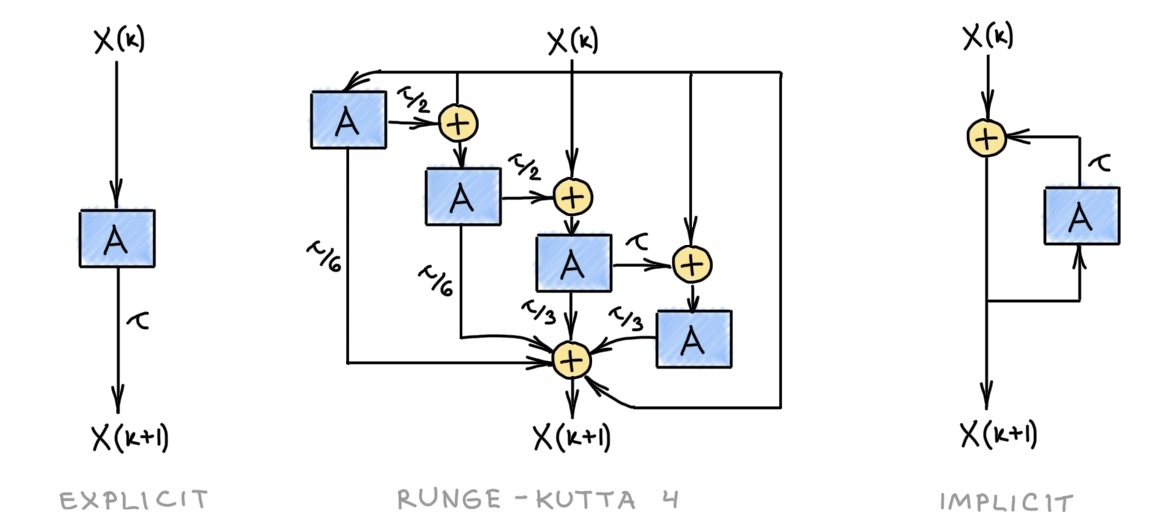

In [ ]:
class HeatLayer(nn.Module):
    """Heat diffusion layer to be implemented by students of practical

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A, step_size, use_W=True, nonlinear=False):
        super(HeatLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A
        self.step_size = step_size
        self.adj_norm = sym_norm_adj(A)

    def forward(self, x):
        y = -(x - torch.sparse.mm(self.adj_norm, x))

        x = x + self.step_size * y
        return x

##Implement a GRAFF layer

We will know implement a simple GRAFF layer from https://arxiv.org/abs/2206.10991. This is like a residual GCN with symmetric weight matrix $W$ and no nonlinearities (although you are welcome to play around with nonlinear activations).

Denoting the symmetric normalised adjacency by $\tilde{A}$, we want to implement $X_{n+1} = X_n + h\tilde{A}X_nW$, where $W$ is constrained to be symmetric and $h$ is again the step-size. Think how you can parametrise $W$ so that is is forced to be symmetric.

In [ ]:
class GRAFFLayer(nn.Module):
    """GRAFF layer to be implemented by students of practical

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A, step_size, use_W=True, nonlinear=False):
        super(GRAFFLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_W = use_W
        self.nonlinear = nonlinear
        self.A = A
        self.step_size = step_size
        self.adj_norm = sym_norm_adj(A)
        if self.use_W:
            self.linear = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x):
        y = torch.sparse.mm(self.adj_norm, x)
        if self.use_W:
            W_temp = self.linear.weight
            W = (W_temp + W_temp.T) / 2
            y = y @ W

        x = x + self.step_size * y
        if self.nonlinear:
            return F.relu(x)
        else:
            return x

We provide below the code necessary to run these layers by stacking multiple such layers. Each layer corresponds to a discretised step of an underlying dynamical system.

In [ ]:
class GNN(nn.Module):
    """Simple encoder decoder GNN model using the various conv layers implemented by students

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        hidden_dim (int): Dimensionality of the hidden feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        step_size (int):
        A (torch.Tensor): 2-D adjacency matrix
        conv_type (str):
    """
    def __init__(self, input_dim, hidden_dim, output_dim, T, step_size, A, conv_type='gcn'):
        super(GNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = int(T // step_size)
        self.A = A

        self.encoder = nn.Linear(input_dim, hidden_dim)
        if conv_type == 'heat':
          self.conv_layer = HeatLayer(hidden_dim, hidden_dim, A, step_size)
        elif conv_type == 'graff':
          self.conv_layer = GRAFFLayer(hidden_dim, hidden_dim, A, step_size)
        self.decoder = nn.Linear(hidden_dim, output_dim)

        self.evolution = []


    def forward(self, x):
        self.evolution = []
        x = self.encoder(x)

        for _ in range(self.layers):
          self.evolution.append(x)
          x = self.conv_layer(x)

        self.evolution.append(x)
        x = self.decoder(x)

        y_hat = F.log_softmax(x, dim=1)
        return y_hat

In [ ]:
def train_gnn_cora(X, y, mask, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(X)[mask]
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_gnn_cora(X, y, mask, model):
    model.eval()
    y_hat = model(X)[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy

# Training loop
def train_eval_loop_gnn_cora_evolutions(model, train_x, train_y, train_mask,
                        valid_x, valid_y, valid_mask,
                        test_x, test_y, test_mask
                    ):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    evolutions = {}
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_gnn_cora(train_x, train_y, train_mask, model, optimiser)
        train_acc = evaluate_gnn_cora(train_x, train_y, train_mask, model)
        valid_acc = evaluate_gnn_cora(valid_x, valid_y, valid_mask, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
            evolutions[f"epoch_{epoch}"] = model.evolution

        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_gnn_cora(test_x, test_y, test_mask, model)
    print(f"Our final test accuracy is: {test_acc:.3f}")
    return training_stats, evolutions

def evaluate_gnn_cora_evol(X, y, mask, model):
    model.eval()
    y_hat = model.decoder(X)[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy

In [ ]:
def get_evolution_stats(model, CoraDataset, evolutions, epoch_idxs=[-1]):

    A = CoraDataset.get_adjacency_matrix()
    edge_index = CoraDataset.cora_data.edge_index
    adj_norm = sym_norm_adj(A)
    train_mask = CoraDataset.train_mask
    valid_mask = CoraDataset.valid_mask
    test_mask = CoraDataset.test_mask

    evol_stats = {}
    for epoch in epoch_idxs:
      epoch_idx=f"epoch_{epoch}"
      evol_stats[epoch_idx] = {}

      train_accs = []
      val_accs = []
      test_accs = []
      energy = []

      for x_t in evolutions[epoch_idx]:
          logits = model.decoder(x_t)
          y_t = F.log_softmax(logits, dim=1)

          train_accs.append(evaluate_gnn_cora_evol(x_t, train_y, train_mask, model))
          val_accs.append(evaluate_gnn_cora_evol(x_t, valid_y, valid_mask, model))
          test_accs.append(evaluate_gnn_cora_evol(x_t, test_y, test_mask, model))
          energy.append(dirichlet_energy(x_t, adj_norm))

      evol_stats[epoch_idx]['train_accs'] = train_accs
      evol_stats[epoch_idx]['valid_accs'] = val_accs
      evol_stats[epoch_idx]['test_accs'] = test_accs
      evol_stats[epoch_idx]['energy'] = energy

      return evol_stats


def plot_evol_stats(evol_stats, figsize=(5, 5), name=""):
    """ Create four plots for each epoch stored in evol_stats
    """
    sorted_epochs = sorted(list(evol_stats.keys()))

    f, ax = plt.subplots(len(sorted_epochs), 2, figsize=figsize)

    for i, epoch in enumerate(sorted_epochs):
      stats = evol_stats[epoch]
      if len(sorted_epochs) > 1:
          #plot accuracies and homophily
          ax[i, 0].plot(torch.stack(evol_stats[epoch]['train_accs']).numpy())
          ax[i, 0].plot(torch.stack(evol_stats[epoch]['valid_accs']).numpy())
          ax[i, 0].plot(torch.stack(evol_stats[epoch]['test_accs']).numpy())
          ax[i, 0].legend()
          #plot dirichlet energy
          ax[i, 1].plot(torch.stack(evol_stats[epoch]['energy']).numpy())
          ax[i, 1].legend()
      else:
          ax[0].plot(torch.stack(evol_stats[epoch]['train_accs']).numpy(), label='train_accs')
          ax[0].plot(torch.stack(evol_stats[epoch]['valid_accs']).numpy(), label='valid_accs')
          ax[0].plot(torch.stack(evol_stats[epoch]['test_accs']).numpy(), label='test_accs')
          ax[0].legend()
          #plot dirichlet energy
          ax[1].plot(torch.stack(evol_stats[epoch]['energy']).numpy(), label='energy')
          ax[1].legend()

In [ ]:
# @title Select conv type

CONV_TYPE =  "heat" #@param {type:"string"}
NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

In [ ]:
Cora  = CoraDataset()
A = Cora.get_adjacency_matrix()
X = Cora.get_fullx()
model = GNN(input_dim=train_x.shape[-1], hidden_dim=32, output_dim=7, T=3, step_size=1.0, A=A, conv_type=CONV_TYPE)
train_mask = Cora.train_mask
valid_mask = Cora.valid_mask
test_mask = Cora.test_mask

# Run training loop
train_stats_gnn_cora, evolutions = train_eval_loop_gnn_cora_evolutions(model, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask)

Epoch 0 with train loss: 1.959 train accuracy: 7.533 validation accuracy: 7.200
Epoch 10 with train loss: 1.805 train accuracy: 42.881 validation accuracy: 41.200
Epoch 20 with train loss: 1.645 train accuracy: 54.636 validation accuracy: 52.400
Epoch 30 with train loss: 1.482 train accuracy: 63.328 validation accuracy: 61.800
Epoch 40 with train loss: 1.314 train accuracy: 72.185 validation accuracy: 69.400
Epoch 50 with train loss: 1.145 train accuracy: 79.222 validation accuracy: 75.600
Epoch 60 with train loss: 0.984 train accuracy: 84.851 validation accuracy: 81.400
Epoch 70 with train loss: 0.840 train accuracy: 87.831 validation accuracy: 84.200
Epoch 80 with train loss: 0.718 train accuracy: 89.404 validation accuracy: 85.600
Epoch 90 with train loss: 0.617 train accuracy: 90.646 validation accuracy: 86.400
Our final test accuracy is: 87.100


In [ ]:
evol_stats = get_evolution_stats(model, Cora, evolutions, epoch_idxs=[NUM_EPOCHS-10])

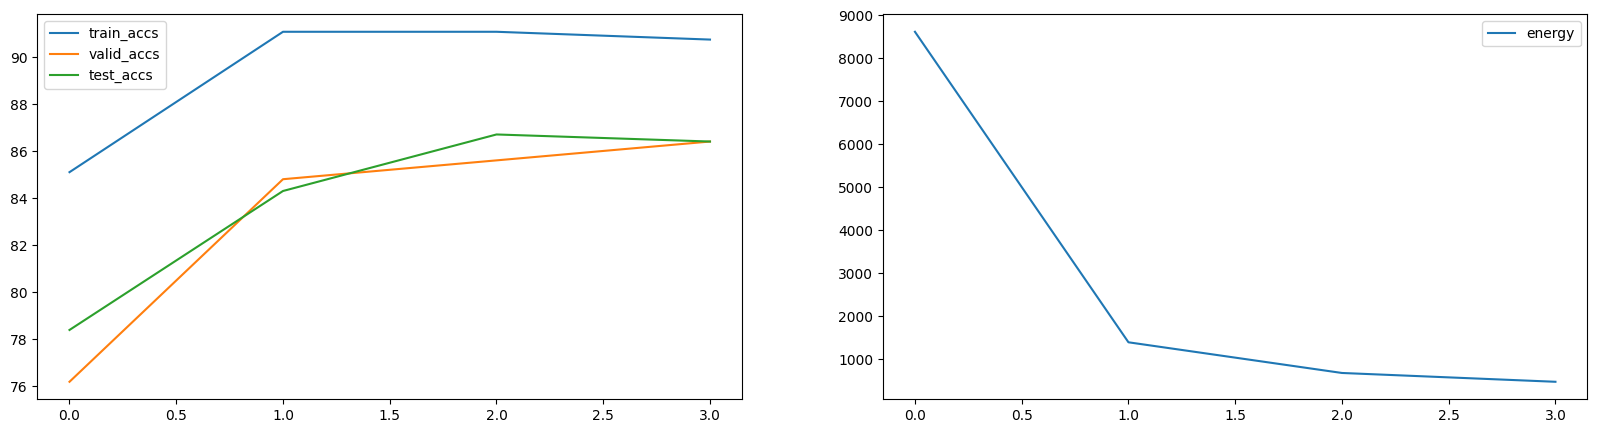

In [ ]:
plot_evol_stats(evol_stats, figsize=(20, 5), name="GNN_Cora")

# Part 2: Sheaf Diffusion

In this part, we will look over some very simple types of Sheaf Neural Networks with stalk dimension $d = 1$. The resulting model is very similar to the GAT model. However, instead of learning an attention matrix, we want to learn a sheaf Laplacian matrix.

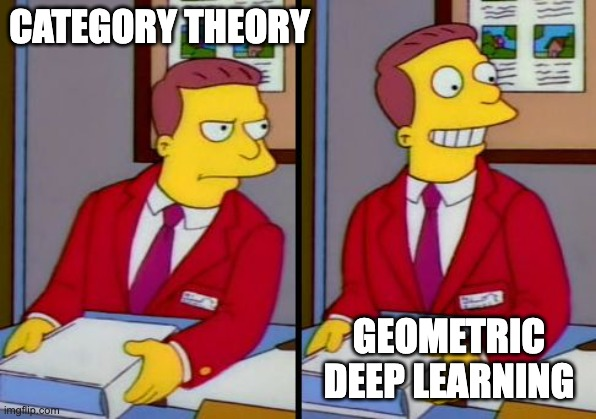

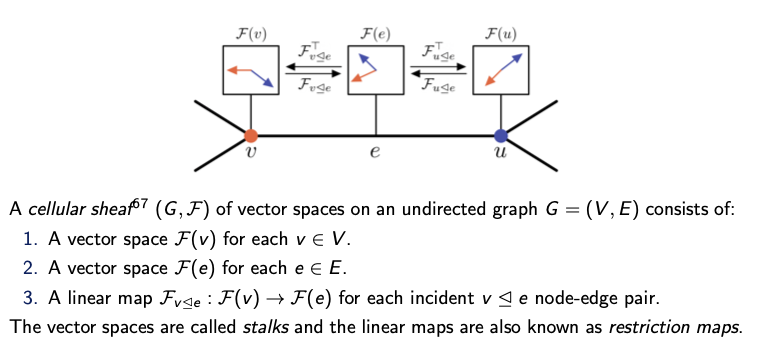

In [ ]:
class SheafConvLayer(nn.Module):
    """A Sheaf Convolutional Network Layer with a learned sheaf.

        Args:
            num_nodes (int): Number of nodes in the graph
            input_dim (int): Dimensionality of the input feature vectors
            output_dim (int): Dimensionality of the output softmax distribution
            edge_index (torch.Tensor): Tensor of shape (2, num_edges)
    """
    def __init__(self, num_nodes, input_dim, output_dim, edge_index, step_size):
        super(SheafConvLayer, self).__init__()
        self.num_nodes = num_nodes
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.edge_index = edge_index
        self.step_size = step_size
        self.linear = nn.Linear(input_dim, output_dim)
        self.sheaf_learner = nn.Linear(2*input_dim, 1, bias=False)
        self.left_idx, self.right_idx = self.compute_left_right_map_index()

        self.adj_norm = sym_norm_adj(to_dense_adj(edge_index)[0])

    def compute_left_right_map_index(self):
        """Computes indices for the full Laplacian matrix"""
        edge_to_idx = dict()
        for e in range(self.edge_index.size(1)):
            source = self.edge_index[0, e].item()
            target = self.edge_index[1, e].item()
            edge_to_idx[(source, target)] = e

        left_index, right_index = [], []
        row, col = [], []
        for e in range(self.edge_index.size(1)):
            source = self.edge_index[0, e].item()
            target = self.edge_index[1, e].item()
            left_index.append(e)
            right_index.append(edge_to_idx[(target, source)])

            row.append(source)
            col.append(target)

        left_index = torch.tensor(left_index, dtype=torch.long, device=self.edge_index.device)
        right_index = torch.tensor(right_index, dtype=torch.long, device=self.edge_index.device)
        left_right_index = torch.vstack([left_index, right_index])

        assert len(left_index) == self.edge_index.size(1)
        return left_right_index

    def build_laplacian(self, maps):
        """Builds the normalised Laplacian from the restriction maps.

        Args:
            maps: A tensor of shape (num_edges, 1) containing the scalar restriction map
                  for the source node of the respective edges in edge_index
            Returns Laplacian as a sparse COO tensor.
        """
        row, col = self.edge_index

        left_maps = torch.index_select(maps, index=self.left_idx, dim=0)
        right_maps = torch.index_select(maps, index=self.right_idx, dim=0)
        non_diag_maps = -left_maps * right_maps
        diag_maps = scatter_add(maps**2, row, dim=0, dim_size=self.num_nodes)

        d_sqrt_inv = (diag_maps + 1).pow(-0.5)
        left_norm, right_norm = d_sqrt_inv[row], d_sqrt_inv[col]
        norm_maps = left_norm * non_diag_maps * right_norm
        diag = d_sqrt_inv * diag_maps * d_sqrt_inv

        diag_indices = torch.arange(0, self.num_nodes, device=maps.device).view(1, -1).tile(2, 1)
        all_indices = torch.cat([diag_indices, self.edge_index], dim=-1)
        all_values = torch.cat([diag.view(-1), norm_maps.view(-1)])
        return torch.sparse_coo_tensor(all_indices, all_values, size=(self.num_nodes, self.num_nodes))


    def predict_restriction_maps(self, x):
        """Builds the normalised Laplacian from the restriction maps.

        Args:
            maps: A tensor of shape (num_edges, 1) containing the scalar restriction map
                  for the source node of the respective edges in edge_index
            Returns Laplacian as a sparse COO tensor.
        """
        row, col = self.edge_index
        x_row = torch.index_select(x, dim=0, index=row)
        x_col = torch.index_select(x, dim=0, index=col)
        maps = self.sheaf_learner(torch.cat([x_row, x_col], dim=1))
        maps = torch.tanh(maps)
        return maps

    def forward(self, x):
        maps = self.predict_restriction_maps(x)
        laplacian = self.build_laplacian(maps)

        y = self.linear(x)
        x = x - self.step_size * torch.sparse.mm(laplacian, y)
        return x

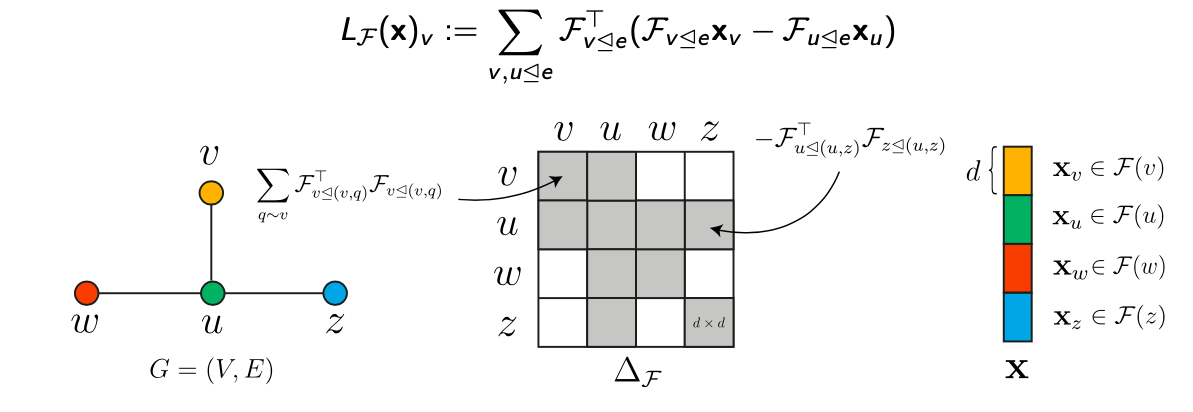

We already provide the structure for a Sheaf Neural Network below. Train your model and analyse the evolution of the Dirichlet energy.

In [ ]:
class SheafNN(nn.Module):
    """Simple encoder decoder GNN model using the various conv layers implemented by students

    Args:
        num_nodes (int): The number of nodes in the graph
        input_dim (int): Dimensionality of the input feature vectors
        hidden_dim (int): Dimensionality of the hidden feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        step_size (int):
        edge_index (torch.Tensor)
    """
    def __init__(self, num_nodes, input_dim, hidden_dim, output_dim, T, step_size, edge_index):
        super(SheafNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = int(T // step_size)

        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.conv_layer = SheafConvLayer(num_nodes, hidden_dim, hidden_dim, edge_index, step_size)
        self.decoder = nn.Linear(hidden_dim, output_dim)

        self.evolution = []


    def forward(self, x):
        self.evolution = []
        x = self.encoder(x)

        for _ in range(self.layers):
          self.evolution.append(x)
          x = self.conv_layer(x)

        self.evolution.append(x)
        x = self.decoder(x)

        y_hat = F.log_softmax(x, dim=1)
        return y_hat

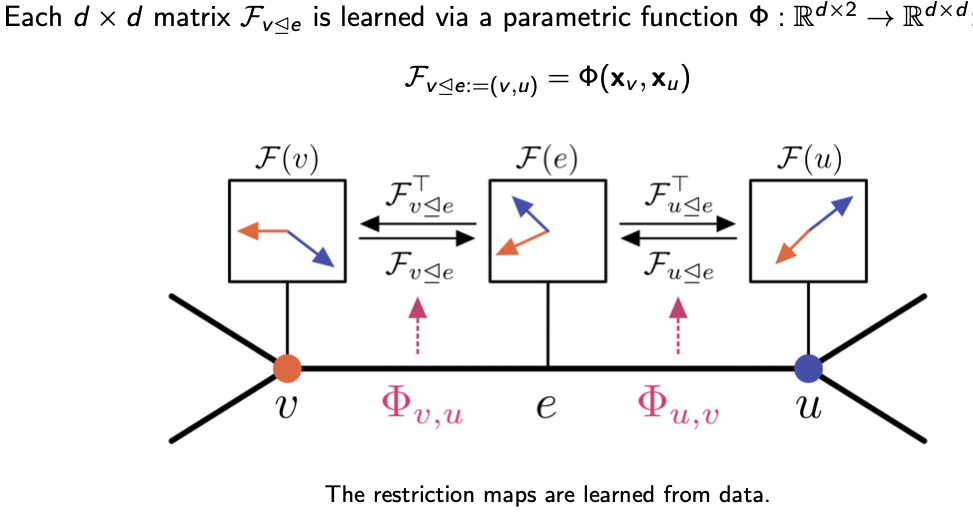

In [ ]:
# @title Select conv type

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

In [ ]:
# Instantiate our model and optimiser
Cora  = CoraDataset()
A = Cora.get_adjacency_matrix()
edge_index = Cora.get_edge_index()
edge_index = remove_self_loops(edge_index)[0]
X = Cora.get_fullx()
model = SheafNN(X.size(0), input_dim=train_x.shape[-1], hidden_dim=32,
                output_dim=7, T=3, step_size=1.0, edge_index=edge_index)

print(train_x.shape)
train_mask = Cora.train_mask
valid_mask = Cora.valid_mask
test_mask = Cora.test_mask

torch.Size([1208, 1433])


In [ ]:
# Run training loop
train_stats_gnn_cora, evolutions = train_eval_loop_gnn_cora_evolutions(model, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask
                                       )

Epoch 0 with train loss: 1.931 train accuracy: 27.483 validation accuracy: 28.600
Epoch 10 with train loss: 1.740 train accuracy: 39.901 validation accuracy: 36.200
Epoch 20 with train loss: 1.532 train accuracy: 51.904 validation accuracy: 43.600
Epoch 30 with train loss: 1.253 train accuracy: 63.411 validation accuracy: 50.800
Epoch 40 with train loss: 0.933 train accuracy: 83.030 validation accuracy: 62.600
Epoch 50 with train loss: 0.616 train accuracy: 90.563 validation accuracy: 70.800
Epoch 60 with train loss: 0.352 train accuracy: 94.040 validation accuracy: 74.800
Epoch 70 with train loss: 0.166 train accuracy: 96.772 validation accuracy: 78.000
Epoch 80 with train loss: 0.080 train accuracy: 98.758 validation accuracy: 79.800
Epoch 90 with train loss: 0.041 train accuracy: 99.421 validation accuracy: 80.800
Our final test accuracy is: 81.500


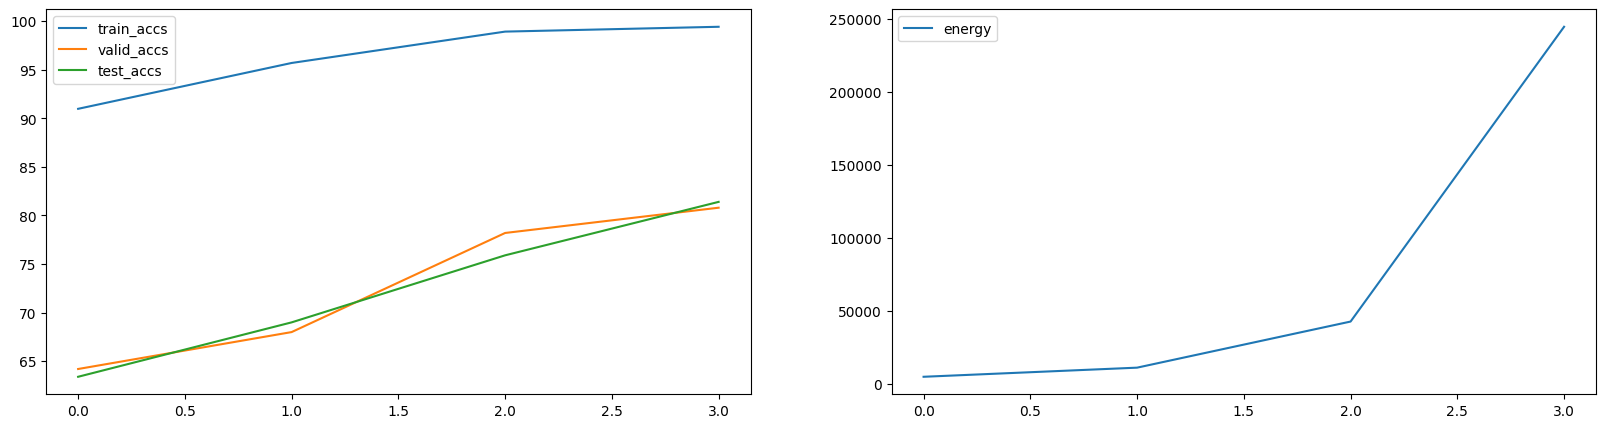

In [ ]:
evol_stats = get_evolution_stats(model, Cora, evolutions, epoch_idxs=[NUM_EPOCHS-10])
plot_evol_stats(evol_stats, figsize=(20, 5), name="SNN_Cora")